# Ex05

#### Objective:
Your boss wants to make groups of type of customer to make a commercial targeting
with offers by e-mails (welcome offers for new customers, coupon to bring back old
customers, special status for loyal customers like: gold, silver, platinum ...)
- Make at least 4 groups (new customer, inactive customer, loyalty status: gold +
silver + platinum ...)
- You have to use a Clustering Algorithms
- Make graphic representations of the groups (minimum 2)

We will use clustering algorithms to group customers into distinct categories based on their behavior. The goal is to identify meaningful customer segments that can guide targeted marketing campaigns


First we import all the libraries:

In [93]:
# First of all, we have to import the necessary libraries
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import glob
import os
import numpy as np
import seaborn as sns

Now let's connect with the DataBase:

In [94]:
DB_NAME = "piscineds"
USER = "ojimenez"
PASSWORD = "mysecretpassword"
HOST = "localhost"
PORT = "5432"

# Let's connect with a SQLAlchemy engine (With psycopg2 we have a Warning):
engine_url = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}"
engine = create_engine(engine_url)

try:
    with engine.connect() as connection:
        print("Connected to the database successfully!")
except Exception as e:
    print(f"Error connecting to the database: {e}")

Connected to the database successfully!


Great! Let's start:

In [11]:
query = """
    SELECT 
        purchase_months_category,
        customer_count,
        avg_purchase_months,
        avg_purchase_frequency,
        purchase_frequency
    FROM (
        SELECT 
            CASE
                WHEN purchase_months = 5 THEN 'loyal platinum'
                WHEN purchase_months IN (3, 4) THEN 'loyal'
                WHEN purchase_months = 2 THEN 'new customer'
                WHEN purchase_months = 1 AND NOT (purchase_month = 1 OR purchase_month = 2) THEN 'inactive'
                WHEN purchase_months = 1 THEN 'new customer'
            END AS purchase_months_category,
            COUNT(DISTINCT user_id) AS customer_count,
            AVG(purchase_months) AS avg_purchase_months,
            AVG(purchase_frequency) AS avg_purchase_frequency,
            AVG(purchase_frequency) AS purchase_frequency
        FROM (
            SELECT 
                user_id,
                COUNT(*) AS purchase_months,
                EXTRACT(MONTH FROM MIN(event_time)) AS purchase_month,
                COUNT(*) * 1.0 / COUNT(DISTINCT user_id) AS purchase_frequency
            FROM 
                customers
            WHERE 
                event_type = 'purchase'
            GROUP BY 
                user_id
        ) AS purchase_counts
        GROUP BY 
            purchase_months_category
        HAVING 
            AVG(purchase_months) BETWEEN 0 AND 6
    ) AS final_result
    ORDER BY 
        customer_count;
"""

try:
    data = pd.read_sql(query, engine)
    print("Query executed successfully :)")
except Exception as e:
    print(f"Error: {e}")
finally:
    engine.dispose()
print(data.head())


Query executed successfully :)
  purchase_months_category  customer_count  avg_purchase_months  \
0                 inactive            6954             1.000000   
1           loyal platinum            7748             5.000000   
2             new customer           16123             1.721516   
3                    loyal           20526             3.467505   

   avg_purchase_frequency  purchase_frequency  
0                1.000000            1.000000  
1                5.000000            5.000000  
2                1.721516            1.721516  
3                3.467505            3.467505  


  purchase_months_category  customer_count  avg_purchase_months  \
0                 inactive            6954             1.000000   
1           loyal platinum            7748             5.000000   
2             new customer           16123             1.721516   
3                    loyal           20526             3.467505   

   avg_purchase_frequency  purchase_frequency  cluster  
0                1.000000            1.000000        2  
1                5.000000            5.000000        0  
2                1.721516            1.721516        1  
3                3.467505            3.467505        3  


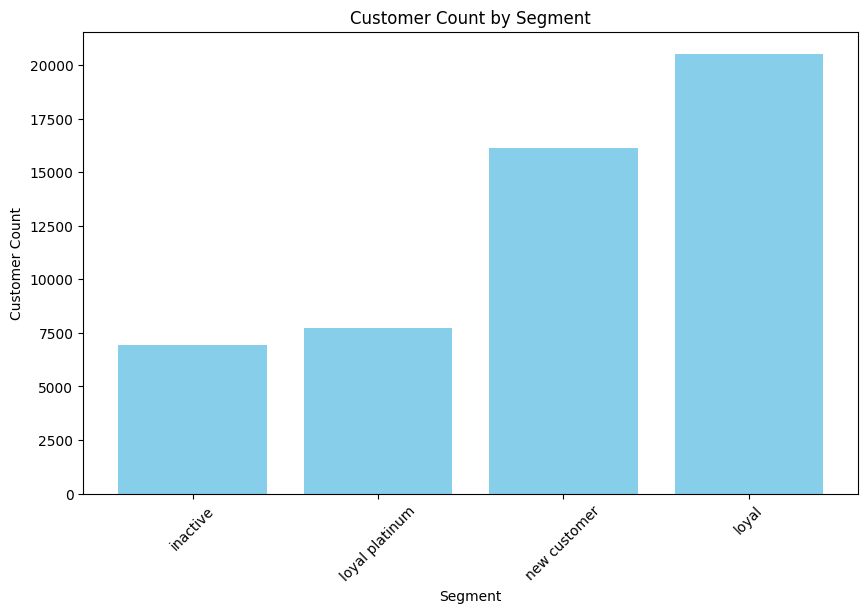

In [28]:
# This first graphic:
plt.figure(figsize=(10, 6))
plt.bar(data['purchase_months_category'], data['customer_count'], color='skyblue')
plt.title('Customer Count by Segment')
plt.xlabel('Segment')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.show()

Now we have the data visualised. Let's follow with the  Clustering Algorithms in order to group our data into meaningful clusters.

__Cluster Algorithm__: A clustering algorithm is an unsupervised learning technique that groups similar data based on their features.


__Objective:__ In our case, the data contains information about different customer segments (purchase_months_category) and their associated metrics (avg_purchase_months, avg_purchase_frequency,...).
The goal of clustering is to identify patterns or natural groupings in the data that may not be immediately obvious.

#### Next Step:
Now we prepare the columns to use a Cluster Algorithm

In [107]:
query = """
    SELECT 
        user_id,
        COUNT(DISTINCT EXTRACT(MONTH FROM event_time)) AS avg_purchase_months,
        COUNT(*) * 1.0 / COUNT(DISTINCT EXTRACT(MONTH FROM event_time)) AS avg_purchase_frequency
    FROM 
        customers
    WHERE 
        event_type = 'purchase'
    GROUP BY 
        user_id
"""

try:
    data = pd.read_sql(query, engine)
    print("Query executed successfully :)")
except Exception as e:
    print(f"Error: {e}")
finally:
    engine.dispose()
print(data.head(20))

Query executed successfully :)
     user_id  avg_purchase_months  avg_purchase_frequency
0    9794320                    1                4.000000
1   10079204                    1                2.000000
2   10280338                    3               28.666667
3   12055855                    1                4.000000
4   12936739                    1                2.000000
5   15400971                    1                3.000000
6   15781728                    1                2.000000
7   19762782                    1                8.000000
8   20554973                    1                7.000000
9   23633626                    1                8.000000
10  25300038                    1                5.000000
11  25392526                    1                3.000000
12  27443691                    1                5.000000
13  27756757                    1                1.000000
14  27872944                    1                5.000000
15  28048440                    1        

In [109]:
#print(data.head(20))

# Normaliza los datos para que tengan media 0 y desviación estándar 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['avg_purchase_months', 'avg_purchase_frequency']])

print("Datos normalizados para KMeans:")
print(X_scaled[:5])

Datos normalizados para KMeans:
[[-0.37686866 -0.43475371]
 [-0.37686866 -0.62510819]
 [ 2.78338766  1.91295146]
 [-0.37686866 -0.43475371]
 [-0.37686866 -0.62510819]]


Let's apply the __KMeans__ algorithm

In [110]:
# Aplica KMeans con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Agrega los centroides de los clusters al DataFrame
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=['avg_purchase_months', 'avg_purchase_frequency'])

print("Centroides de los clusters:")
print(centroids_df)

Centroides de los clusters:
   avg_purchase_months  avg_purchase_frequency
0             1.000000                6.251584
1             3.486778               13.343476
2             2.000000                9.048181
3             1.153214               39.811112


manual_cluster
Inactive          88042
New Customer      11218
Loyal              5748
Loyal Platinum     5476
Name: count, dtype: int64


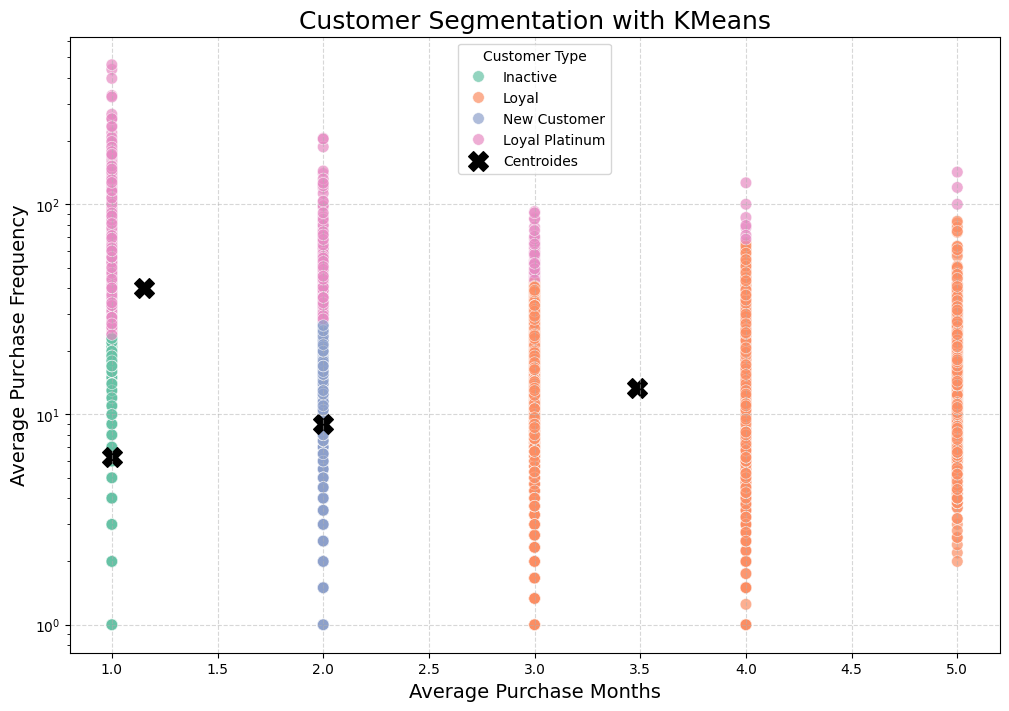

In [114]:
# Crear una nueva columna para la segmentación manual
data['manual_cluster'] = data['cluster'].map({
    0: "Inactive",
    1: "Loyal",
    2: "New Customer",
    3: "Loyal Platinum"
})

# We count the amount of people per cluster
cluster_sizes = data['manual_cluster'].value_counts()
print(cluster_sizes)

# Gráfico de dispersión con los clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data,
    x='avg_purchase_months',
    y='avg_purchase_frequency',
    hue='manual_cluster',
    palette='Set2',
    s=70,              # tamaño de los puntos
    alpha=0.7,         # transparencia
    edgecolor='w',     # borde blanco
    linewidth=0.5
)

# Añadir centroides manualmente
plt.scatter(
    centroids_df['avg_purchase_months'],
    centroids_df['avg_purchase_frequency'],
    c='black',
    marker='X',
    s=200,
    label='Centroides'
)

plt.title('Customer Segmentation with KMeans', fontsize=18)
plt.xlabel('Average Purchase Months', fontsize=14)
plt.ylabel('Average Purchase Frequency', fontsize=14)
plt.yscale('log')  # Como ya habías puesto
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Customer Type')
plt.show()

#### Now let's see another graphic:

<Figure size 1000x600 with 0 Axes>

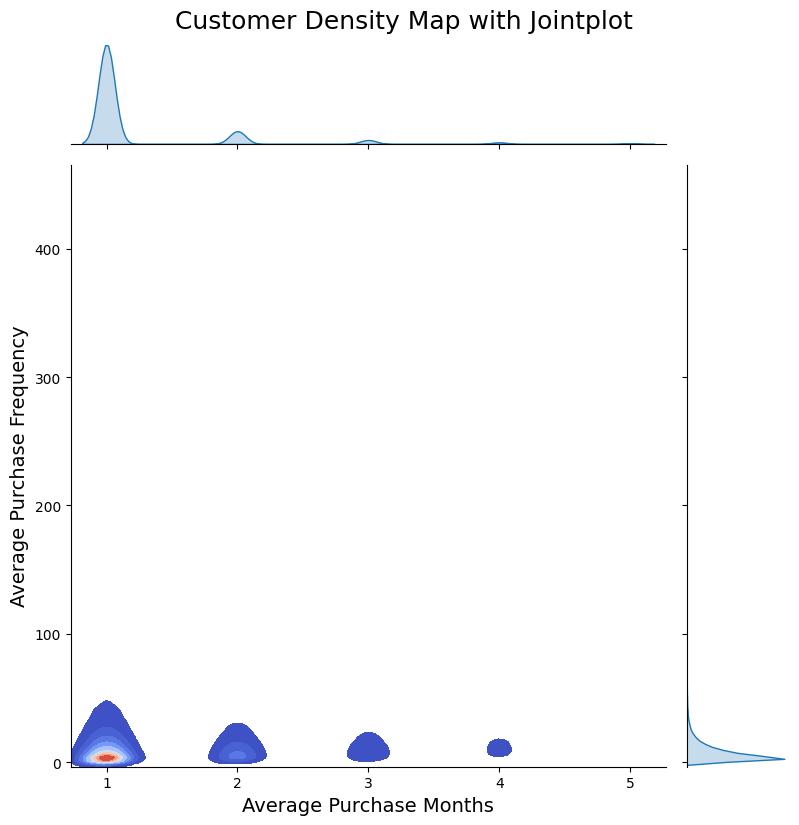

In [121]:
# Crear el Jointplot con KDE
plt.figure(figsize=(10, 6))
sns.jointplot(
    data=data,
    x='avg_purchase_months',
    y='avg_purchase_frequency',
    kind='kde',  # Esto le dice que use KDE
    fill=True,   # Rellenar el gráfico con color
    cmap='coolwarm',  # Cambia el mapa de colores
    height=8,  # Tamaño de la figura
)

# Añadir título y etiquetas (por defecto, Jointplot ya tiene su propio título)
plt.suptitle('Customer Density Map with Jointplot', fontsize=18, y=1.02)  # Ajustar título
plt.xlabel('Average Purchase Months', fontsize=14)
plt.ylabel('Average Purchase Frequency', fontsize=14)

plt.show()